# Prepare

In [1]:
import os # for file handling
import pathlib # for reading files
import pandas as pd # for reading csv files
import numpy as np # for numerical operations
from PIL import Image # for opening images
import shutil # for moving files
import matplotlib.pyplot as plt # for plotting

import tensorflow as tf # for deep learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Check GPU

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

TensorFlow version: 2.10.1
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']


# Load Data using Keras utility

In [3]:
data_dir = pathlib.Path('C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\cats_prey_training_2024_06_06')

Define parameters for loader

In [4]:
batch_size = 32
#Larger batches also provide a more accurate estimate of the gradient, but they require more memory.

img_height = 480
img_width = 480

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 333 files belonging to 2 classes.
Using 267 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 333 files belonging to 2 classes.
Using 66 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [7]:
class_names = train_ds.class_names
print(class_names)

['n', 'y']


# Visualize the Data

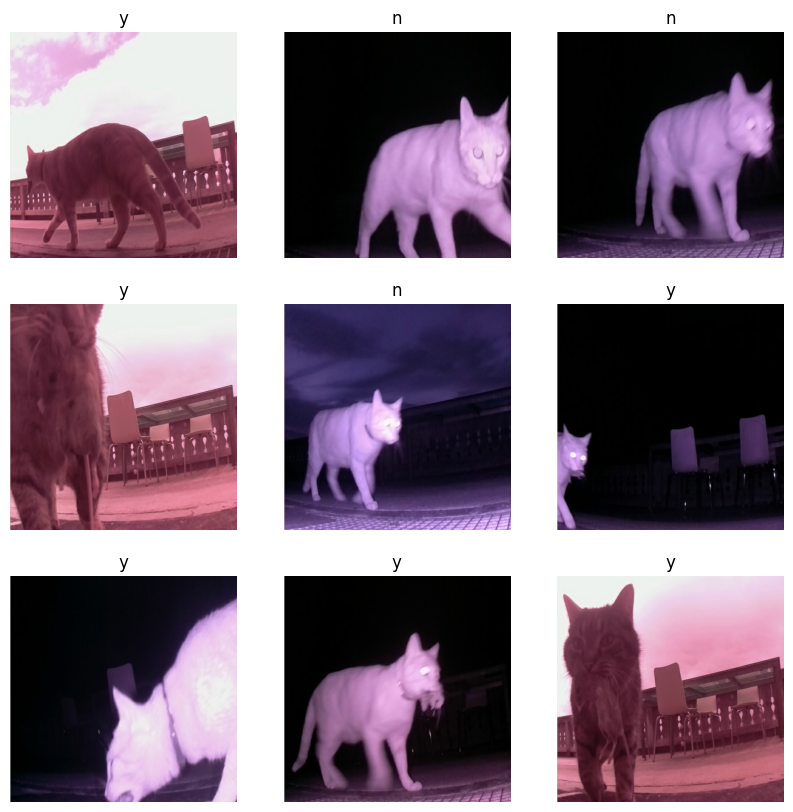

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 480, 480, 3)
(32,)


An image can be represented as a 3-D tensor. For a color image, the dimensions might correspond to height, width, and color channels (RGB). The `image_batch` is a tensor of the shape `(32, 480, 480, 3)`. This is a batch of 32 images of shape `480x480x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

# Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# A basic Keras model with Dropout Layers

### Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [ ]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid') # Binary classification
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

In [ ]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(21) # adjust this to the number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Not good, total overfit

# Add Data Augmentation Layer

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Visualize Augmented Data

Visualize a few augmented examples by applying data augmentation to the same image several times:

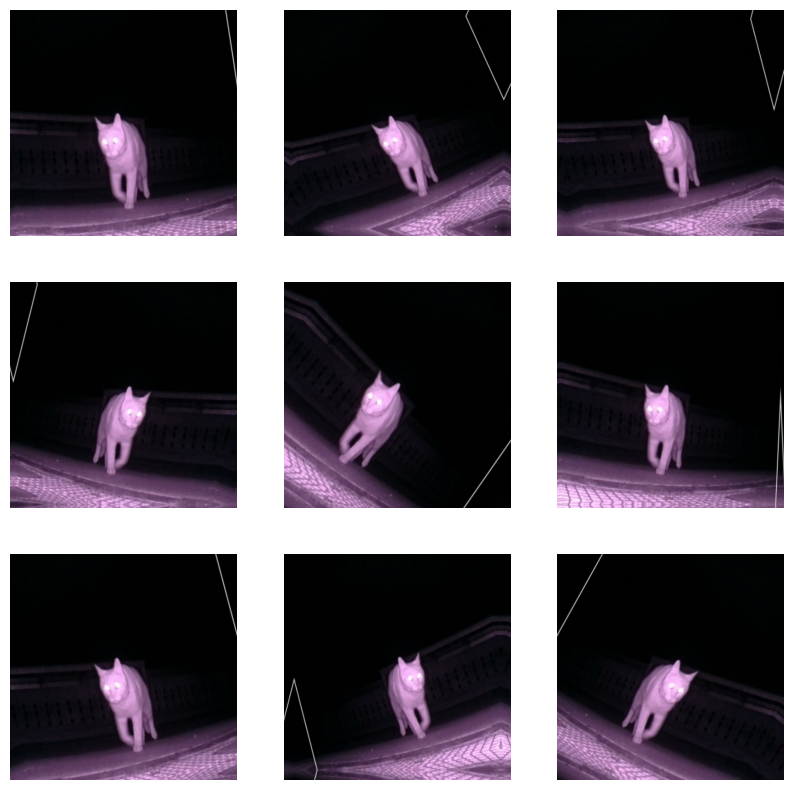

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images, training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create Model with Data Augmentation Layer

In [13]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),# input shape already defined in data_augmentation layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid') # Binary classification
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

Number of classes: 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 480, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 480, 480, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 240, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 240, 240, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 32)      4640      
                                 

In [14]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
9/9 [==============================] - 4s 194ms/step - loss: 2.5158 - accuracy: 0.5281 - val_loss: 0.6931 - val_accuracy: 0.4697 - lr: 0.0010
Epoch 2/500
9/9 [==============================] - 1s 156ms/step - loss: 0.6916 - accuracy: 0.5693 - val_loss: 0.6885 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 1s 166ms/step - loss: 0.6611 - accuracy: 0.6742 - val_loss: 0.6820 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 1s 106ms/step - loss: 0.6527 - accuracy: 0.5955 - val_loss: 0.6836 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 1s 156ms/step - loss: 0.6405 - accuracy: 0.6404 - val_loss: 0.6799 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 1s 154ms/step - loss: 0.6345 - accuracy: 0.6517 - val_loss: 0.6764 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 1s 155ms/step - loss: 0.6

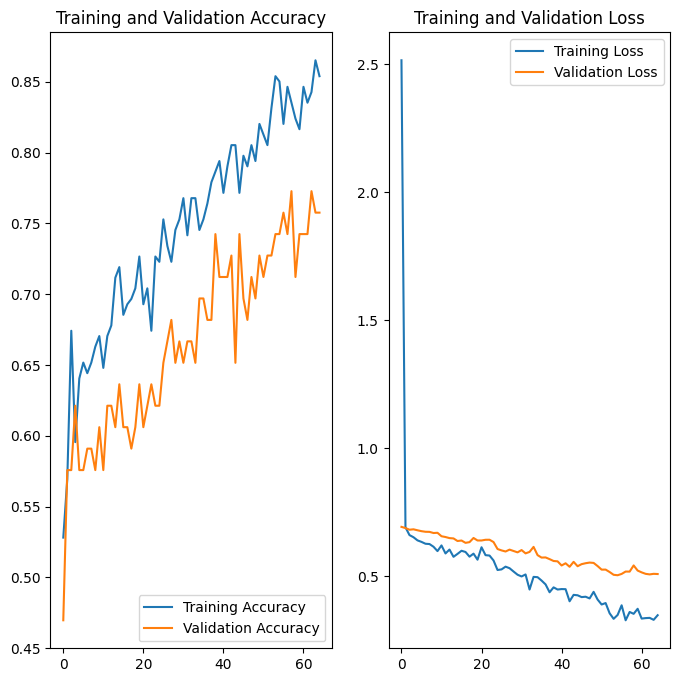

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(65) # adjust this to the number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

better

# Using grayscale images (experimental)
For detecting prey, color is less important (than for distinguishing between cats). Without color, the model can focus on shapes, textures, and patterns, which may be more relevant for detecting prey.

In [ ]:
# Custom grayscale conversion layer
class GrayscaleLayer(layers.Layer):
    def __init__(self):
        super(GrayscaleLayer, self).__init__()

    def call(self, inputs):
        return tf.image.rgb_to_grayscale(inputs)

# Data augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 1)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ]
)

# Define the model
model = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    GrayscaleLayer(),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images, training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

This strange lines in the image is because for some reason we have a white line at the left border of the image. Has this something to do with the camera case?

In [ ]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(26) # adjust this to the number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is happening here?!